# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**
+ _the Smartcab does <b>NOT move</b> at all during the simulation when running the <b>default agent.py</b>_
+ _There are TWO category of scalar rewards that the driving agent receives:_
    - _Positive rewards [Idle default agent coinccidently complies safety rule], e.g. following rewarded: +1.87, +2.04, +1.22, +0.54, etc._
    - _Negative rewards [Idle default agent coinccidently violates safety rule], e.g. following rewarded: -5.86, -4.50, -4.88, -4.79, etc._
+ _In the simulation, traffic light is presented with TWO parallel line segments (RED) at cross in different configurations:_
    - _When they are parallel with the agent's heading direction, it means traffic light is GREEN_
    - _When they are perpendicular with the agent's heading direction, it means traffic light is RED_
    - _Given the default agent is always IDLE, it is easy to understand the observation that agent is always positively rewarded on RED light, and negatively rewarded on GREEN when there is no other traffic_
    - _We also observe that IDLE agent (Smartcab) is offered a small positive reward on GREEN with L-Turn oncoming traffic, this makes sense considering conservative driving experience (to avoid collision) in real world_ 

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**
+ In `agent.py`, there are many flags to augment the simulation, some are very obvious, such as `num_dummies` and `grid_size` to configure the number of other (background) cars in the environment and the size of the environment at its creation, but the real interesting THREE relevant to learning that I'd like to highlight are:
    - _`learning`, set to True to force the driving agent to use Q-learning, default is False_
    - _`epsilon`, continuous value between [0, 1] for the exploration factor, default is 1_
    - _`alpha`, continuous value between [0, 1] for the learning rate, default is 0.5_
+ In `environment.py`, class `Environment` function `act()` is called when an agent performances an action. It returns `reward` if the agent in question is the Smartcab (primary_agent)
+ In `simulator.py`, class `Simulator` function `render_text()` is the non-GUI render display of the simulation vs. `render()` is the GUI render display of the simulation
+ In `planner.py`, class `RoutePlanner` function `next_waypoint()`, when difference between Smartcab current location and destination exist in both _North-South_ (`dy != 0`) and _East-West_ (`dx != 0`) directions, it always considers the _East-West_ direction first

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


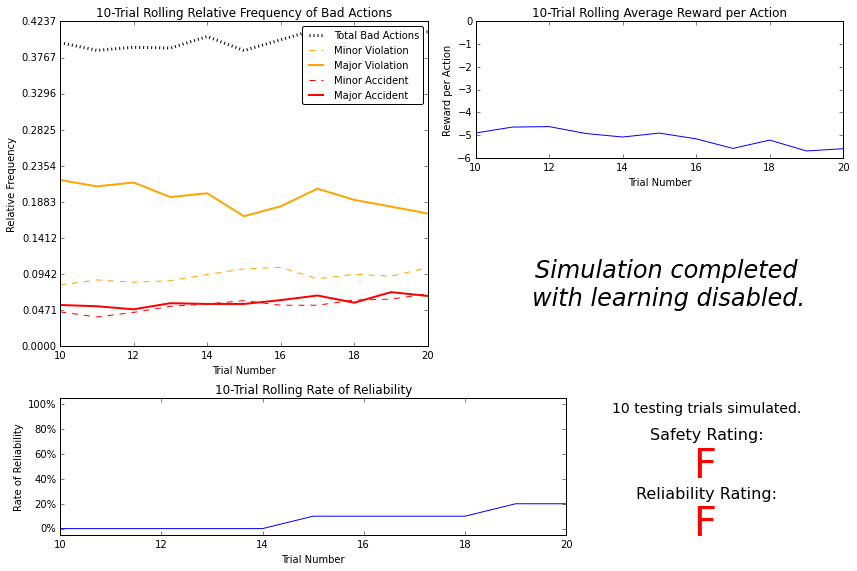

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

##### From the visualization above, we could see that
+ Agent is not trained to drive `safely` and `reliably`, since both `Safety Rating` and `Reliability Rating` are `F`
+ Agent's percentage (`Rolling Realtive Frequency`) of `Bad Actions` is not improving over training, `Total` and each `Violation` or `Accident` Relative Frequency fluctuate in the same range, since Smartcab is not learning
+ Also due to not learning, its `Reward per Action` (Rolling Average) kept in low negative ranges (-4.5 ~ -5.5) consistently
+ And Smartcab's `Rate of Reliability` (rolling average of reach destination in time) was low <= 20%

##### According to the 20 training trials (random destination) visualization above, we also know that
+ The driving agent is making <b>_37.67% ~ 42.37%_ bad decisions</b> (Relative Frequency of `Total Bad Actions`) from trial to trial. Out of the total, approximate <b>_4.00% ~ 7.00%_ bad decisions</b> cause `Minor` accidents (red dash lines), and <b>_4.70% ~ 7.20%_ bad decisions</b> cause `Major` accidents (red solid lines), considering both `Minor` and `Major`, <b>_approximate 8.70% ~ 14.20%_</b> bad secisions cause accidents
+ Given that the agent is driving randomly, the `Rate of Reliability` makes sense that they were all very low `< 20%` from trial to trial (the 10 rolling rate's stepping of 0% => 10% => 20% from train trial #10 to #20 was coinccident)
+ From the 10 rolling average reward per action, the agent normally received negative reward (_approxiamte -4.5 ~ -5.5_) per move. This none negligible negative average suggests that the agent had been often penalized heavily
+ There is <b>NO</b> significant trend of changes to reporting results as the number of trials increases, due to randomness
+ This initial Smartcab is <b>NOT</b> considered safe and reliable for passengers, because the result grade is <b>F</b> to both <b>Safety</b> and <b>Reliability</b> according to 10 <b>testing</b> trials!

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:**
- Ideally all features that are available to the agent are relevant for Smartcab learning both <b>safety</b> and <b>efficiency</b>', out of those:
    + `deadline` is mostly relevant and dependent upon training vs. testing, notice that it is already modeled to `penalty` in `act()` and valuated separately in `step()` of `Eviornment` class functions, so it is unnecessary to be part of Smartcab agent state
    + `waypoint` and `inputs` are the most relevant features for Smartcab to learn both <b>safety</b> and <b>efficiency</b>
- `waypoint` and `inputs` are appropriate for modeling the agent state, because they represent minimum set of simplified (according to Simulation environment) information that Smartcab requires to make traffic rule comforming action, also are aquirable to the real world scenario. Specifically:
    + `inputs` simulates what a real Smartcab can and be required to observe at a cross on real street to drive <b>Safely</b>
    + `waypoint` represents target (destination location) determined features to guide the learning and planning
    + Notice that not all features from `inputs` are equally independent (according to real world traffic rule), e.g. inputs[`right`] might be an unnecessary feature to Smartcab state if `dummy agents` can't do U-Turn, so it may be irrelevant to Smartcab's driving behaviour regardless of inputs[`light`], etc. I will try to optimize state space further to this regard in the Agent improve phase later. For now all `inputs` features are kept for the initial try out.
- `deadline` is not very appropriate in modeling Smartcab state, because it is not learning relevant feature in that:
    + It is already modeled into soft `penalty` in environment
    + It is also evaluated separately in enviornment to claim a `success` run
    + It is none stationary, init value depends upon none deterministic `distance` from run to run
    + Even though, if it is included, then state space would blow up, we would suffer from the curse of dimensionality, and it would take a long time for the Q-table to be converged in training


### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**
- Once an agent state is defined using features `waypoint` and `inputs`, the size of the state space (number of possible states) is:
    + num_of_waypoint `*` num_of_inputs[light] `*` num_of_inputs[left] `*` num_of_inputs[right] `*` num_of_inputs[oncoming] = 3 `*` 2 `*` 4 `*` 4 `*` 4 = 384
- N.B. that we have not included `deadline` and `grid location` as state variable, so state space is relatively not too big. Reason to do so being:
    + we are training the Smartcab to learn basic driving practice, problem is reduced to generic traffic rule learning problem vs. an optimal planning problem where agent is required to track its own location in state at each step. Here the policy learned is `grid/cross location` agnostic, it is a common `policy` across all locations instead! (notice that neither `start` nor `destination` is explicitly given for train or test)
    + As mentioned earlier, we do not include `deadline` (Remaining deadline) in state, because:
        - `penalty` already explicitly models `deadline` in `class Environment function act()`, no need to `learn` use it again
        - Initial `deadline` isn't stationary value to begin with, it is derived from travel `distance`, they both aren't meaningful learning feature
    + If add `deadline` & `grid location` to state, space will explode by `max(grid_size*deadline)` times in size, provided they were given
- Given that now agent state space is not huge in design, we believe the Smartcab agent could learn a policy for each possible state within a reasonable number of training trials

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

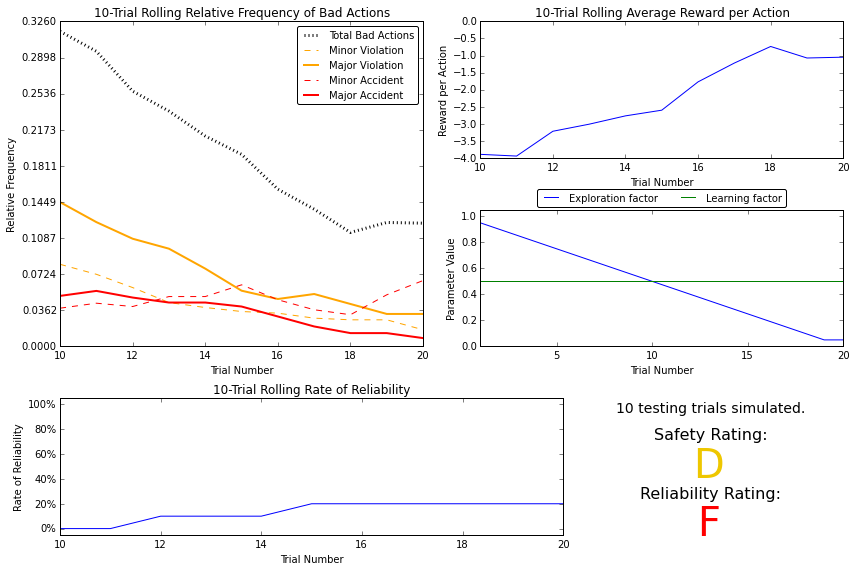

In [3]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

#### Compare to the result from Question 3 above, we have very different visualization here, which confirms Agent's learning.

##### From the visualization above, we see that
+ Default Q-learning Agent demonstrated improvement to drive safely, `Safety Rating` improved from `F` to `D`, but `Reliability Rating` was still `F`
+ Agent's percentage (`Rolling Realtive Frequency`) of `Bad Actions` is improving over training, `Total` and each `Violation` or `Accident` (except for `Minor Accident`) Relative Frequency show decline over the trainingin, these prove that Smartcab is learning
+ Also due to progressive learning, its `Reward per Action` (Rolling Average) increased from -4.0 at beginning to -1.0 to the end approximately
+ `Exploration factor` showed linear decline from 1.0 to close to 0.0, this is consistent with implemented linear delay of epsilon parameter. `Learning factor` was consistent at 0.5, which also complies with default `learning rate` alpha (0.5) 
+ But Smartcab's `Rate of Reliability` (rolling average of reach destination in time) was still low <= 20%, probably due to the `SLOW` in learning (relative to the default deadline setting), `SHORT` in training (default 20 episodes) or non-optimal Q-learning parameters, such as initial epsilon=1.0, etc.

##### According to the 20 training trials (random destination) visualization above, we conclude that
+ Major improvements were seen from even the default Q-learning Smartcab. But low rating of `Rate of Reliability` was still observed, similar to the previous basic driving agent
+ Approximately 20 training trials were required before testing (epsilon < threshold), it made sense provided that
    - Initial epsilon = 1.0
    - Linear epsilon decay is implemented (-0.05 at each trial)
    - Default threshold is 0.05 (as in code, no change)
+ Linear decay function of ϵ (the exploration factor) was accurately represented in the parameters panel (it showed linear decrease from 0.95 to 0.05)
+ As the number of training trials increased, overall the number of bad actions decreased, and the average reward increased
+ The `Safty Rating` improved to `D` from initial basic driving agent
+ The `Reliability Rating` was not improved, still at `F`
+ This default Q-learning Smartcab is <b>still NOT</b> considered safe and reliable for passengers, an optimized Q-learning agent should be made!

##### We also come to know that 20 trials of training is far below necessary to train an agent of state space size of 384, I will address the training trials issue together with state space optimization coming next!



-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

### N.B. Important optimization note:
+ Optimized Agent State (according to traffic rule), shrink agent state space from (state space size: 384 => 96):
    - `(waypoint, inputs['light'], inputs['left'], inputs['right'], inputs['oncoming'])`
+ to
    - `(waypoint, inputs['light'], inputs['oncoming'], inputs['left'])`

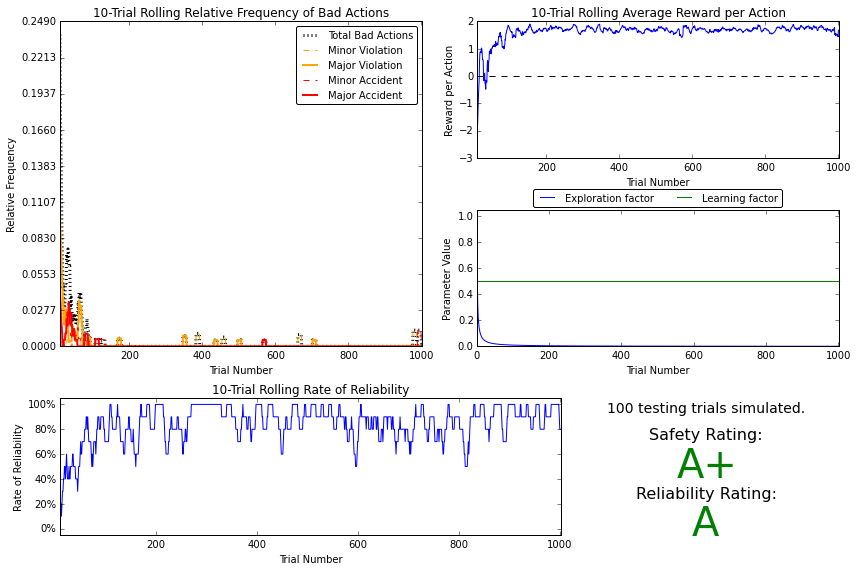

In [4]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**
+ The decaying function that I used for epsilon (the exploration factor) is: $$\epsilon = \frac{1}{t} $$
    - I also consider any function close to linear or cosine a good option, in short epsilon needs to decay but not too fast
+ Continue from the ending of Question 6, we need adequent training trials to gain confident result (Q-table), provided the state space of size 96. Consider multiple folds bigger to the state space, 500~1000 would be an approxiamte good number for training trials before testing. 
+ In my optimization, provide above epsilon decaying function, initial _`epsilon=1.0`_ and _`epsilon-tolerance`_ is set to `0.001`, to yield 1000 training trials prior to Smartcab agent testing run. On the contrary, I used constant learning rate _`alpha=0.5`_
+ These are the main improvements that were made to this optimized Q-learner comparing to prior default one:
    - Condensed State Space, space size changes from 384 to 96, more feasible to training
    - Increased the number of training trials from default 20 (to 1000, via adjust _`tolerance`_ given _`epsilon decay`_)
    - Increased the number of testing trials (from default 10 to 100) to provide more reliable testing result
    - Introduced a different _`epsilon decaying function`_ than the prior default linear one
    - Code refactoring to include both cases, using only existing flags
+ From simulated testing trials, new results demonstrated that our Smartcab driving agent had successfully learned an appropriate policy (from Q-table)
+ I am satisfied with both the _<b>`Safety Rating: A+`</b>_ and _<b>`Reliability Rating: A`</b>_ of this Smartcab:
    - _`Safety`_ first, it has achieve the best rating of `A+`
    - _`Efficiency or Reliability`_ is very important but not crucial, I think <b>80% on time</b> or rating above <b>`B`</b> is acceptable

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

In [27]:
from collections import OrderedDict
import pandas as pd

examples = OrderedDict([ ('Driving Plan (waypoint)', ['Forward', 'Right', 'Left']),
          ('Traffic Light', ['Green', 'Red', 'Green']),
          ('Driving Rule (to planned waypoint) / Optimal Policy',
           ['Go', 'Go-after-Wait (when no merging traffic)', 'Go-w-Yield (when no oncoming forward traffic)'])])
drv_examples = pd.DataFrame.from_dict(examples)
drv_examples

,Driving Plan (waypoint),Traffic Light,Driving Rule (to planned waypoint) / Optimal Policy
0,Forward,Green,Go
1,Right,Red,Go-after-Wait (when no merging traffic)
2,Left,Green,Go-w-Yield (when no oncoming forward traffic)


**Answer:** 

    Given new state: (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])
+ According Traffic Rules, 3 typical <b>human driving examples with optimal policy</b> are listed in <b>above table</b> for us to compare, investigate Smartcab learned drive policies.
+ Smartcab learned policies investigation from `sim_improved-learning.txt`:
    - For the first <b>_Driving Example_</b> (`drv_examples[0]`), we have following learned Q-table entries:

        ('forward', 'green', 'right', 'right')
           -- forward : 2.51
           -- right : 0.00
           -- None : -2.22
           -- left : 0.00
 
        ('forward', 'green', None, 'right')
            -- forward : 1.87
            -- right : 0.27
            -- None : -2.70
            -- left : 0.00
 
        ('forward', 'green', None, None)
            -- forward : 1.16
            -- right : 0.46
            -- None : -3.97
            -- left : 0.20
 
        ('forward', 'green', 'forward', 'right')
            -- forward : 1.74
            -- right : 0.00
            -- None : 0.00
            -- left : 0.00
 
        ('forward', 'green', 'left', 'right')
            -- forward : 2.10
            -- right : 0.00
            -- None : 0.00
            -- left : 0.00
 
        ('forward', 'green', 'forward', None)
            -- forward : 2.23
            -- right : 0.00
            -- None : -2.47
            -- left : 0.00
 
        ('forward', 'green', 'right', None)
            -- forward : 1.47
            -- right : 0.00
            -- None : 0.00
            -- left : -9.66
            
        + <b>Conclusion</b> from above Q-table samples: correct policy (action with the highest value) <b>`forward`</b> is given
            
    - For the second <b>_Driving Example_</b> (`drv_examples[1]`), we observed following 2 different learned Q-table policies:
    
        <b>Stop -or- Idle</b> whenever unsafe to pull out and turn `Right`, note:
            I.  In 1st sample below, it could turn `Right` if it waited already
            II. Following 3 samples, it picked `safe` to stay `Stop` to avoid `merging` traffic
        
        
        ('right', 'red', None, None)
            -- forward : -9.84
            -- right : 0.00
            -- None : 2.07
            -- left : -7.29

        ('right', 'red', 'left', 'right')
            -- forward : 0.00
            -- right : 0.00
            -- None : 2.30
            -- left : 0.00

        ('right', 'red', 'right', 'forward')
            -- forward : -20.49
            -- right : -10.13
            -- None : 1.95
            -- left : 0.00

        ('right', 'red', None, 'forward')
            -- forward : -20.34
            -- right : -17.23
            -- None : 1.73
            -- left : 0.00

    
        Turn-Right whenever safe, note:
        
            I. Following 3 samples, there were no merging traffic to avoid, when it turned Right

        ('right', 'red', 'right', 'left')
            -- forward : -4.78
            -- right : 2.48
            -- None : 0.00
            -- left : 0.00
 
        ('right', 'red', 'right', None)
            -- forward : -4.62
            -- right : 1.40
            -- None : 0.00
            -- left : 0.00
 
        ('right', 'red', 'right', 'right')
            -- forward : -5.35
            -- right : 1.94
            -- None : 0.00
            -- left : 0.00

        Conclusion from above Q-table samples: correct policy either STOP -or- Turn-Right is given


    For the 3rd Driving Example (drv_examples[2]), we also observed 2 different learned Q-table policies:
    
        Turn-Left when safe (no oncoming forward traffic)

        ('left', 'green', None, None)
            -- forward : 0.95
            -- right : -0.09
            -- None : -4.20
            -- left : 1.72

        ('left', 'green', 'left', None)
            -- forward : -0.01
            -- right : 0.49
            -- None : 0.00
            -- left : 1.14
 
 
        Move-Forward when there is oncoming forward traffic, note:
        I.   this obeyed safety rule
        II.  but it might not be optimal in real world, where roads are not simple grid of uniformed grid length
        III. forward vs. None is chosen, may due to the incurred remaining deadline penalty given by environment 

        ('left', 'green', 'forward', None)
            -- forward : -0.05
            -- right : -0.09
            -- None : -2.15
            -- left : -9.83
 
        ('left', 'green', 'forward', 'right')
            -- forward : 0.91
            -- right : 0.00
            -- None : 0.00
            -- left : 0.00


        Conclusion from above Q-table samples: reasonable policy either Turn-Left -or- Forward is given


+ The last two samples (state: ['left', 'green', 'forward', None/'right']) have not yield an optimal policy (i.e. None -or- Wait) according to human practice from real world, but it is a safeand acceptable one in this simulation enviornment, with above reasoning and analysis provided.

+ There are many example states computed with correct policies, here is specific one coming with detailed explaination (embedded follow each action):

    <b>State: Agent-Intended-Move:`right`, Traffic-Light:`red`, Oncoming-Traffic:`None`, Leftcoming-Traffic:`forward`</b>
    
            ('right', 'red', None, 'forward')
    <b>Actions: `reward`</b>

            -- forward : -20.34   * Bad move(big penalty): 1.Crash with forward traffic from Left, 2.Detour
            -- right : -17.23     * Bad move(major penalty): Crash with forward traffic from left at merge!
            -- None : 1.73        * Best action: it is wait, comply with human driving!
            -- left : 0.00        * Bad move(N/A penalty): Can't turn Left at Red light,
                                    and it will crash with forward traffic from Left, it's penalty is 0.0
                                    because this action in the state has not been sampled yet in training!

    <b>Conclusion: This state-actions rewards record reveals `correct policy` of this state</b>


-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**
+ Smartcab itself:
    - Agent only senses it's own waypoint (driving intend), traffic light and immediate traffic from 3 cross directions just ONE-STEP/grid away.
    - By (simulation) design, Smartcab itself does NOT know or have memory for:
        + Where it started (no way to tracking path)
        + Where is destination (no way to plan)
        + Grid configuration (no way to localize)
    - Also Agent does NOT observe any farther than just 1-step ahead, it is purely egocentric in this simulation, `future` environment is stochastic
+ Environment:
    - The `random` movement of dummy agents around the next state of Smartcab is not perceivable, provided that Smartcab is not equiped with long vision sensory (e.g. bird-view of the grid map itself). Since we don't know the environment configuration 2-steps (or more) ahead, future reward term can't be estimated.
    - `destination` is not perceivable to Smartcab given the environment, and it is also not deterministic in this environment, it is picked randomly from run-to-run. So to the Smartcab point of view, it can't possibly learn where the goal (state) is from the environment. When future state is unknown, so as the future reward estimate.

Provided all these, there is <b>no sensible heuristic to the future estimation</b> (e.g. moving towards a goal) to be made (in this simulation setting), so we end up with <b>not using the discount factor `gamma`</b>.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.